In [3]:
!pip install torch

     |████████████████████████████████| 150.6 MB 168 kB/s  eta 0:00:01     |█████████████████████████████▌  | 138.9 MB 30.8 MB/s eta 0:00:01


In [4]:
!pip3 install torch_geometric

In [8]:
!pip install torch torchvision

     |████████████████████████████████| 1.7 MB 3.1 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [35]:
import torch
from torch_geometric.data import Data
import torch.nn.functional as F

# num_classes = 3
# edge_index = torch.tensor([[0, 1, 1, 2, 3, 2],
#                            [1, 0, 2, 1, 2, 3]], dtype=torch.long)
# x = torch.tensor([[], [], [], []], dtype=torch.float)
# y = torch.tensor([[0, 1, 0], [0, 0, 1], [1, 0, 1], [1, 0, 0]], dtype=torch.float)
# train_mask = torch.tensor([True, True, False, False], dtype=torch.bool)
# test_mask = torch.tensor([False, False, True, True], dtype=torch.bool)
# x
# data = Data(x=x, edge_index=edge_index, y=y, train_mask=train_mask, test_mask=test_mask)
# data

In [64]:
from torch.utils.data import random_split

data = torch.load('sample_GNN_data.pt')
print(data)

# Assuming 'dataset' is your entire dataset
dataset_size = data.x.shape[0]
print(dataset_size)
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size

train_dataset, test_dataset = random_split(data.x, [train_size, test_size])

# Now you can create masks based on the lengths of train_dataset and test_dataset
train_mask = torch.zeros(dataset_size, dtype=torch.bool)
test_mask = torch.zeros(dataset_size, dtype=torch.bool)
train_mask[list(train_dataset.indices)] = True
test_mask[list(test_dataset.indices)] = True

data.test_mask = test_mask
data.train_mask = train_mask
num_classes = data.y.shape[1]
print(data.test_mask)
print(data.train_mask)
data

Data(x=[179, 0], edge_index=[2, 1008], y=[179, 327])
179
tensor([False, False, False, False, False, False, False, False,  True, False,
        False, False, False, False, False,  True, False, False, False, False,
        False, False, False, False, False, False, False,  True,  True,  True,
        False, False, False, False,  True, False, False, False, False, False,
        False,  True,  True, False,  True, False, False, False, False, False,
        False, False, False,  True, False,  True,  True,  True, False, False,
        False, False, False, False, False, False, False, False, False,  True,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False,  True, False, False,  True, False,  True, False,
        False,  True, False, False, False, False, False,  True, False,  True,
        False, False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False,  True, False, False, False, False,
       

Data(x=[179, 0], edge_index=[2, 1008], y=[179, 327], test_mask=[179], train_mask=[179])

In [69]:
# tensorboard
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

RuntimeError: module compiled against API version 0xf but this version of numpy is 0xd

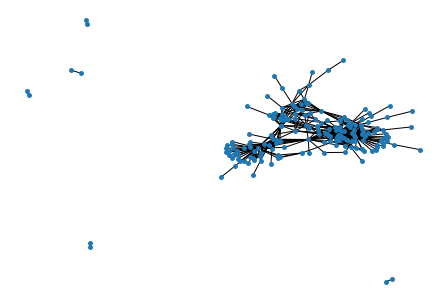

In [65]:
import networkx as nx
import torch_geometric.utils

g = torch_geometric.utils.to_networkx(data, to_undirected=True)
nx.draw(g, node_size=15)

In [66]:
import torch_geometric.nn

class GCNModel(torch.nn.Module):
    def __init__(self, num_nodes, hidden_size=32):
        super(GCNModel, self).__init__()
        self.node_embedding = torch.nn.Embedding(num_nodes, hidden_size)
        # Initialize the embeddings with small random values
        torch.nn.init.normal_(self.node_embedding.weight, std=0.1)
        self.conv1 = torch_geometric.nn.GCNConv(hidden_size, 16)
        self.conv2 = torch_geometric.nn.GCNConv(16, num_classes)

    def forward(self, data):
        edge_index = data.edge_index
        x = self.node_embedding.weight

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.softmax(x, dim=1)

In [67]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCNModel(len(data.x)).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# sets the model in training mode
# When you call model.train(), PyTorch enables features such as dropout and 
# batch normalization, which are typically used during training but not during inference
model.train()
for epoch in range(100):
    optimizer.zero_grad()
    out = model(data)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    if(epoch % 10 == 0):
        print(epoch, loss)
    # writer.add_scalar("Loss/train", loss, epoch)
    optimizer.step()

# writer.flush()

0 tensor(9.0291, grad_fn=<DivBackward1>)
10 tensor(9.0284, grad_fn=<DivBackward1>)
20 tensor(9.0272, grad_fn=<DivBackward1>)
30 tensor(9.0227, grad_fn=<DivBackward1>)
40 tensor(8.9970, grad_fn=<DivBackward1>)
50 tensor(8.7522, grad_fn=<DivBackward1>)
60 tensor(8.6642, grad_fn=<DivBackward1>)
70 tensor(8.6386, grad_fn=<DivBackward1>)
80 tensor(8.6377, grad_fn=<DivBackward1>)
90 tensor(8.5427, grad_fn=<DivBackward1>)


In [68]:
from sklearn.metrics import f1_score, precision_score, recall_score

model.eval()
pred = model(data)
print(pred[:10])
# Convert probabilities to binary predictions
binary_pred = (pred >= 1.0/num_classes).float()
# Check if each prediction matches the label for each instance
correct = (binary_pred[data.test_mask] == data.y[data.test_mask]).sum() / num_classes
acc = int(correct) / int(data.test_mask.sum())

print(f'Accuracy: {acc:.4f}')
precision = precision_score(data.y[data.test_mask], binary_pred[data.test_mask], average='micro')
print(f'Precision: {precision:.4f}')
recall = recall_score(data.y[data.test_mask], binary_pred[data.test_mask], average='micro')
print(f'Recall: {recall:.4f}')
f1 = f1_score(data.y[data.test_mask], binary_pred[data.test_mask], average='micro')
print(f'F1 Score: {f1:.4f}')

tensor([[9.7455e-01, 1.2658e-06, 1.2599e-06,  ..., 1.2371e-06, 1.2315e-06,
         1.2316e-06],
        [9.4696e-01, 6.1827e-06, 6.1648e-06,  ..., 6.0673e-06, 6.0594e-06,
         6.0509e-06],
        [9.5951e-01, 1.6134e-05, 1.6013e-05,  ..., 1.5759e-05, 1.5688e-05,
         1.5701e-05],
        ...,
        [9.7411e-01, 3.6677e-06, 3.6455e-06,  ..., 3.5815e-06, 3.5680e-06,
         3.5686e-06],
        [9.8800e-01, 8.2436e-07, 8.1795e-07,  ..., 8.0183e-07, 7.9658e-07,
         7.9787e-07],
        [9.7587e-01, 9.1535e-07, 9.1270e-07,  ..., 8.9583e-07, 8.9407e-07,
         8.9309e-07]], grad_fn=<SliceBackward0>)
Accuracy: 0.9722
Precision: 0.3371
Recall: 0.5882
F1 Score: 0.4286
